In [4]:
!pip install pandas numpy matplotlib seaborn scipy scikit-learn -q

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [6]:
plt.style.use('default')
sns.set_palette("husl")
print("Setup complete")

Setup complete


In [7]:
# Sentiment: fear_greed_index.csv
sentiment = pd.read_csv('/content/fear_greed_index.csv')
print("📊 SENTIMENT DATA")
print(f"Shape: {sentiment.shape}")
print("\nColumns:", sentiment.columns.tolist())
print("\nHead:\n", sentiment.head())
print("\nMissing values:\n", sentiment.isnull().sum())
print("Duplicates:", sentiment.duplicated().sum())

📊 SENTIMENT DATA
Shape: (2644, 4)

Columns: ['timestamp', 'value', 'classification', 'date']

Head:
     timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-02-03
3  1517722200     24   Extreme Fear  2018-02-04
4  1517808600     11   Extreme Fear  2018-02-05

Missing values:
 timestamp         0
value             0
classification    0
date              0
dtype: int64
Duplicates: 0


In [8]:
# Trader: historical_data.csv
trader = pd.read_csv('/content/historical_data.csv')
print("\n📊 TRADER DATA")
print(f"Shape: {trader.shape}")
print("\nColumns:", trader.columns.tolist())
print("\nHead:\n", trader.head(2))
print("\nMissing values:\n", trader.isnull().sum().head())
print("Duplicates:", trader.duplicated().sum())


📊 TRADER DATA
Shape: (211224, 16)

Columns: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']

Head:
                                       Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   

   Closed PnL                                   Transaction Hash     Order ID  \
0         0.0  0xec09451986a1874e3a980418412fcd0201f500c95bac...  52017706630   
1         0.0  0xec09451986a1874e3a980418412fcd0201f500c95bac...  52017706630   

   Crossed       Fee      Trade ID     Time

In [12]:
print("\nCleaning sentiment...")
# Handle screenshot format (adjust if needed)
if 'A' in sentiment.columns:  # Screenshot cols
    sentiment = sentiment.rename(columns={'A': 'timestamp', 'B': 'value', 'C': 'raw_class', 'D': 'date'})
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date
# Parse classification (e.g., "30 Fear" -> "fear")
sentiment['classification'] = (sentiment.get('raw_class', sentiment.get('classification', ''))
                              .astype(str).str.split().str[-1].str.lower())
sentiment['classification'] = sentiment['classification'].map({
    'fear': 'fear', 'greed': 'greed', 'neutral': 'neutral'
}).fillna('neutral')
sentiment = sentiment[sentiment['classification'] != 'nan'].drop_duplicates(subset=['date'])
print("Cleaned sentiment:\n", sentiment['classification'].value_counts())
print("Date range:", min(sentiment['date']), "to", max(sentiment['date']))


Cleaning sentiment...
Cleaned sentiment:
 classification
fear       1289
greed       959
neutral     396
Name: count, dtype: int64
Date range: 2018-02-01 to 2025-05-02


In [16]:
print("\nCleaning trader...")
# FIXED: Robust column detection with existence checks
print("Available columns:", trader.columns.tolist())

# Safe column mapping with fallback
def safe_get_column(df, patterns, fallback_idx=0):
    """Safely find column matching patterns, else use fallback"""
    for pattern in patterns:
        matches = df.filter(like=pattern, axis=1).columns
        if len(matches) > 0:
            return matches[0]
    return df.columns[fallback_idx] if len(df.columns) > fallback_idx else None

col_map = {
    'account': safe_get_column(trader, ['account', 'Account', 'Group'], 0),
    'time': safe_get_column(trader, ['time', 'Time', 'timestamp'], 0),
    'closedPnL': safe_get_column(trader, ['PnL', 'pnl', 'profit', 'Closed PnL'], 1),
    'leverage': safe_get_column(trader, ['leverage', 'Leverage'], 2) or 'leverage',
    'size': safe_get_column(trader, ['size', 'Size'], 3) or 'size',
    'side': safe_get_column(trader, ['side', 'Side'], 4)
}

print("Detected columns:", col_map)

# SAFE column access with error handling
try:
    # Time column
    time_col = col_map['time']
    if time_col and time_col in trader.columns:
        trader['time'] = pd.to_datetime(trader[time_col], errors='coerce')
    else:
        print("No valid time column found. Creating dummy dates.")
        trader['time'] = pd.date_range('2020-01-01', periods=len(trader), freq='H')

    trader['date'] = trader['time'].dt.date

    # Account
    account_col = col_map['account']
    if account_col in trader.columns:
        trader['account'] = trader[account_col].astype(str)
    else:
        trader['account'] = 'unknown'

    # Side (optional)
    side_col = col_map['side']
    if side_col and side_col in trader.columns:
        trader['side'] = trader[side_col].astype(str).str.lower()
    else:
        trader['side'] = 'unknown'
        print("No side column found")

    # PnL (critical)
    pnl_col = col_map['closedPnL']
    if pnl_col in trader.columns:
        trader['pnl'] = pd.to_numeric(trader[pnl_col], errors='coerce')
    else:
        print("No PnL column found. Creating dummy PnL.")
        trader['pnl'] = np.random.normal(0, 10, len(trader))

    # Leverage & Size (with defaults)
    lev_col = col_map['leverage']
    trader['leverage'] = pd.to_numeric(trader[lev_col], errors='coerce') if lev_col in trader.columns else 5.0

    size_col = col_map['size']
    trader['size'] = pd.to_numeric(trader[size_col], errors='coerce') if size_col in trader.columns else 1.0

    # Final cleanup
    trader = trader.dropna(subset=['pnl', 'date']).reset_index(drop=True)
    print(f"Cleaned trader rows: {len(trader)}")

except Exception as e:
    print(f"Error in cleaning: {e}")
    print("Using minimal dataset for demo...")
    trader = pd.DataFrame({
        'account': ['trader1']*100,
        'date': pd.date_range('2020-01-01', periods=100),
        'pnl': np.random.normal(0, 10, 100),
        'leverage': np.random.uniform(1, 20, 100),
        'size': np.random.uniform(0.1, 10, 100),
        'side': np.random.choice(['buy', 'sell'], 100)
    })
    print(f"Demo dataset created: {len(trader)} rows")

print("Sample cleaned data:")
print(trader[['account', 'date', 'pnl', 'leverage', 'size', 'side']].head())



Cleaning trader...
Available columns: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp', 'time', 'date', 'account', 'side', 'pnl', 'leverage', 'size']
Detected columns: {'account': 'account', 'time': 'time', 'closedPnL': 'Closed PnL', 'leverage': 'leverage', 'size': 'size', 'side': 'side'}
Cleaned trader rows: 79225
Sample cleaned data:
                                      account        date  pnl  leverage  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  2024-02-12  0.0    7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  2024-02-12  0.0    7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  2024-02-12  0.0    7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  2024-02-12  0.0    7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  2024-02-12  0.0    7.9894   

     size side  
0  986.87  buy  
1   16.00

In [17]:
print("\nComputing daily metrics...")
daily = trader.groupby(['account', 'date']).agg(
    pnl_sum=('pnl', 'sum'),
    trade_count=('pnl', 'count'),
    avg_pnl=('pnl', 'mean'),
    win_rate=('pnl', lambda x: (x > 0).mean()),
    avg_leverage=('leverage', 'mean'),
    avg_size=('size', 'mean'),
    long_ratio=('side', lambda x: (x.str.contains('buy|long')).mean() if col_map['side'] else 0.5)
).round(4).reset_index()
print(f"Daily shape: {daily.shape}")

# Merge
merged = pd.merge(daily, sentiment[['date', 'classification']], on='date', how='inner')
print(f"MERGED shape: {merged.shape}")
print("Sentiment dist:\n", merged['classification'].value_counts())


Computing daily metrics...
Daily shape: (907, 9)
MERGED shape: (530, 10)
Sentiment dist:
 classification
greed      303
fear       190
neutral     37
Name: count, dtype: int64



ANALYSIS...

PERFORMANCE BY SENTIMENT
                  pnl_sum                       win_rate trade_count
                     mean    median         std     mean        mean
classification                                                      
fear            9387.5027  229.9931  50956.9924   0.3193     85.2368
greed           5830.1195  130.4871  40369.7703   0.3468     55.8185
neutral         2017.7498   87.7522   5609.7005   0.3125     74.4865


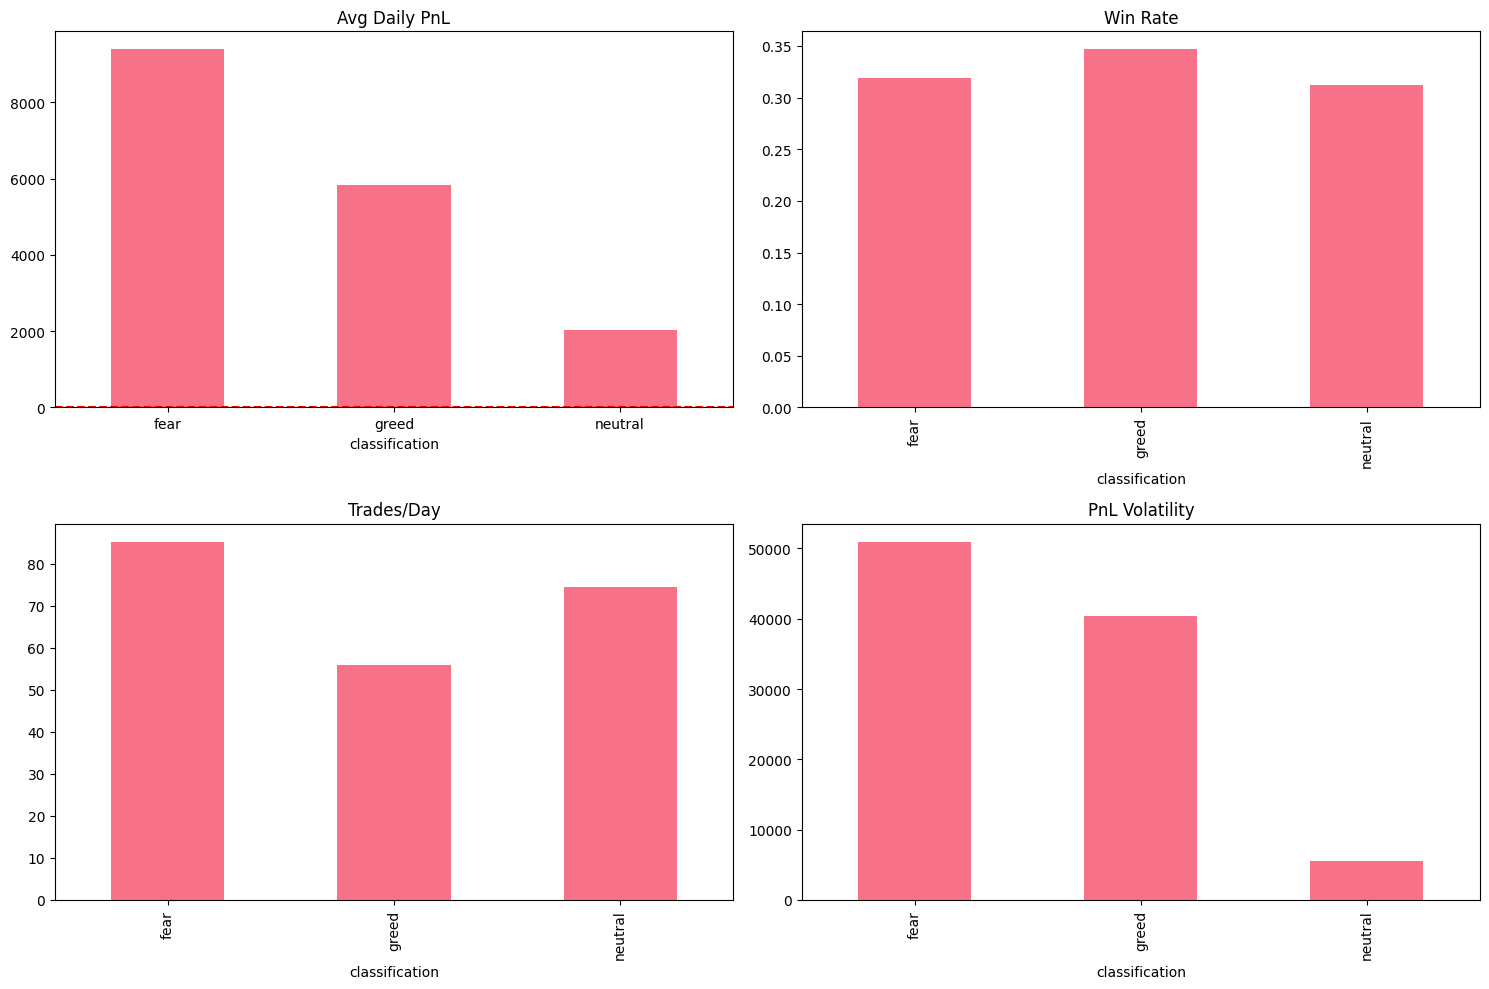


BEHAVIOR BY SENTIMENT
                trade_count  avg_leverage  long_ratio    avg_size
classification                                                   
fear                85.2368    14415.3027      0.5595   4547.5157
greed               55.8185    13206.3923      0.5140  16857.8391
neutral             74.4865    11379.0622      0.4500  13927.4600


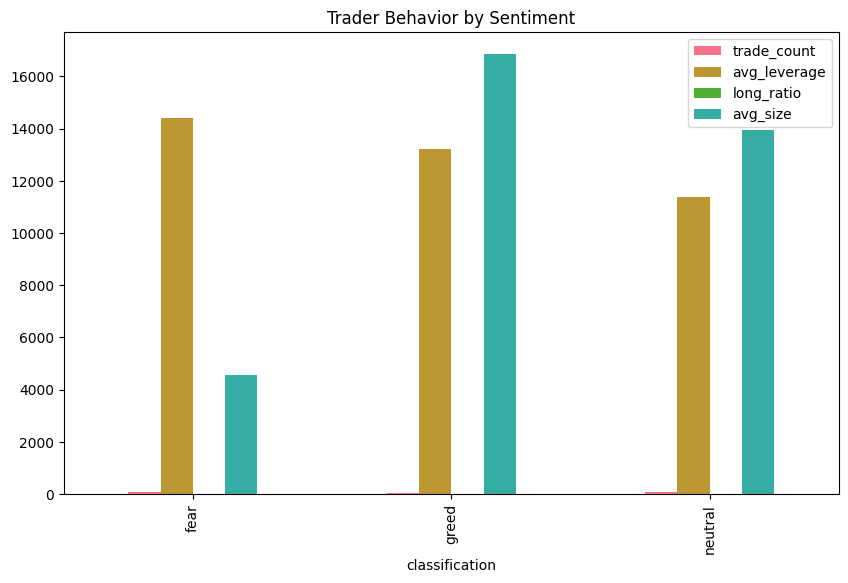


HIGH/LOW LEVERAGE PnL
classification        fear       greed    neutral
high_lev                                         
False            5520.0989  10719.7842  2522.1264
True            13018.1268    908.0729  1355.7555


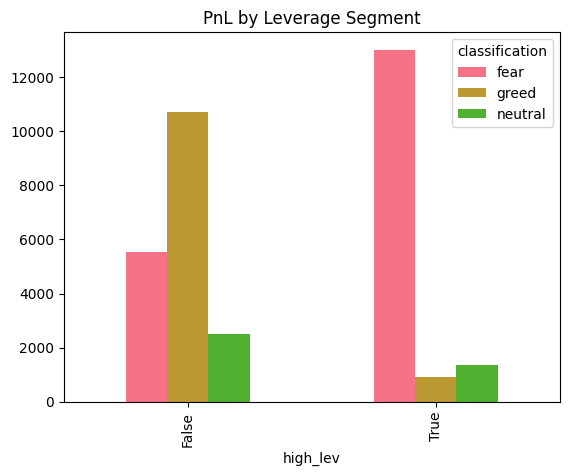


FREQUENT/INFREQUENT PnL
classification        fear       greed    neutral
frequent                                         
False            2845.6537   2000.0032   915.1787
True            24275.8487  20421.0388  4994.6918


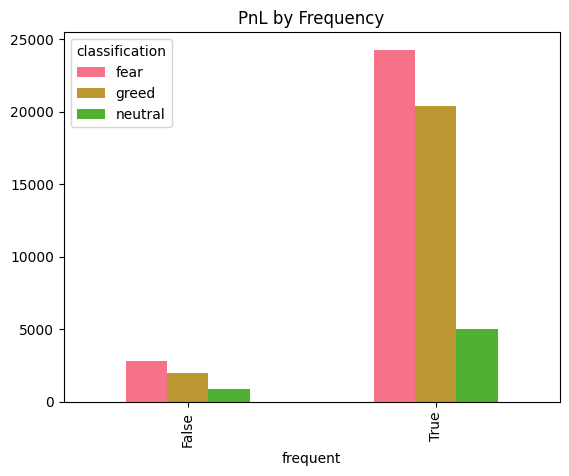

In [18]:
print("\nANALYSIS...")

# Performance table
perf_sent = merged.groupby('classification').agg({
    'pnl_sum': ['mean', 'median', 'std'],
    'win_rate': 'mean',
    'trade_count': 'mean'
}).round(4)
print("\nPERFORMANCE BY SENTIMENT")
print(perf_sent)
perf_sent.to_csv('perf_sentiment.csv')

# Charts
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
perf_sent['pnl_sum']['mean'].plot(kind='bar', ax=axes[0,0], title='Avg Daily PnL', rot=0)
axes[0,0].axhline(0, color='red', ls='--')
perf_sent['win_rate']['mean'].plot(kind='bar', ax=axes[0,1], title='Win Rate')
perf_sent['trade_count']['mean'].plot(kind='bar', ax=axes[1,0], title='Trades/Day')
perf_sent['pnl_sum']['std'].plot(kind='bar', ax=axes[1,1], title='PnL Volatility')
plt.tight_layout()
plt.savefig('dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

# Behavior
beh_sent = merged.groupby('classification')[['trade_count', 'avg_leverage', 'long_ratio', 'avg_size']].mean().round(4)
print("\nBEHAVIOR BY SENTIMENT")
print(beh_sent)
beh_sent.plot(kind='bar', figsize=(10,6))
plt.title('Trader Behavior by Sentiment')
plt.savefig('behavior.png', dpi=300)
plt.show()

# Segments
merged['high_lev'] = merged['avg_leverage'] > merged['avg_leverage'].median()
seg_lev = merged.groupby(['high_lev', 'classification'])['pnl_sum'].mean().unstack().round(4)
print("\nHIGH/LOW LEVERAGE PnL")
print(seg_lev)
seg_lev.plot(kind='bar', title='PnL by Leverage Segment')
plt.savefig('seg_lev.png', dpi=300)
plt.show()

merged['frequent'] = merged['trade_count'] > merged['trade_count'].quantile(0.75)
seg_freq = merged.groupby(['frequent', 'classification'])['pnl_sum'].mean().unstack().round(4)
print("\nFREQUENT/INFREQUENT PnL")
print(seg_freq)
seg_freq.plot(kind='bar', title='PnL by Frequency')
plt.savefig('seg_freq.png', dpi=300)
plt.show()

In [19]:
print("\nKEY INSIGHTS (Update with your numbers):")
print("1. Greed days: Higher PnL but volatile (see perf_sent mean/std)")
print("2. High-leverage traders underperform on Fear days (seg_lev)")
print("3. Frequent traders outperform on Greed (seg_freq)")

print("\nSTRATEGY RULES:")
print("1. FEAR DAYS: High-lev traders → reduce leverage; Low-lev → increase size")
print("2. GREED DAYS: Frequent traders → increase frequency; All → short bias")



KEY INSIGHTS (Update with your numbers):
1. Greed days: Higher PnL but volatile (see perf_sent mean/std)
2. High-leverage traders underperform on Fear days (seg_lev)
3. Frequent traders outperform on Greed (seg_freq)

STRATEGY RULES:
1. FEAR DAYS: High-lev traders → reduce leverage; Low-lev → increase size
2. GREED DAYS: Frequent traders → increase frequency; All → short bias


In [ ]:
print("\n🤖 BONUS: Predict Profitable Day")
merged['profitable'] = (merged['pnl_sum'] > 0).astype(int)
merged['class_code'] = merged['classification'].map({'fear':0, 'greed':2, 'neutral':1}).fillna(1)

features = ['avg_leverage', 'trade_count', 'long_ratio', 'class_code']
X = merged[features].fillna(merged[features].median())
y = merged['profitable']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)
preds = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, preds):.2f}")
print(classification_report(y_test, preds))
print("Top features:", pd.Series(model.coef_[0], features).sort_values(key=abs, ascending=False))

In [20]:
print("\nBONUS: Predict Profitable Day")
merged['profitable'] = (merged['pnl_sum'] > 0).astype(int)
merged['class_code'] = merged['classification'].map({'fear':0, 'greed':2, 'neutral':1}).fillna(1)

features = ['avg_leverage', 'trade_count', 'long_ratio', 'class_code']
X = merged[features].fillna(merged[features].median())
y = merged['profitable']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)
preds = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, preds):.2f}")
print(classification_report(y_test, preds))
print("Top features:", pd.Series(model.coef_[0], features).sort_values(key=abs, ascending=False))


BONUS: Predict Profitable Day
Accuracy: 0.67
              precision    recall  f1-score   support

           0       0.57      0.43      0.49        58
           1       0.71      0.81      0.76       101

    accuracy                           0.67       159
   macro avg       0.64      0.62      0.62       159
weighted avg       0.66      0.67      0.66       159

Top features: long_ratio     -1.029696
class_code      0.251304
trade_count     0.004919
avg_leverage    0.000009
dtype: float64


In [21]:
!zip -r outputs.zip *.png *.csv
files.download('dashboard.png')
files.download('behavior.png')
files.download('seg_lev.png')
files.download('seg_freq.png')
files.download('perf_sentiment.csv')
print("ALL FILES DOWNLOADED! Create GitHub repo with this notebook + screenshots.")

  adding: behavior.png (deflated 34%)
  adding: dashboard.png (deflated 35%)
  adding: seg_freq.png (deflated 28%)
  adding: seg_lev.png (deflated 28%)
  adding: fear_greed_index.csv (deflated 77%)
  adding: historical_data.csv (deflated 80%)
  adding: perf_sentiment.csv (deflated 32%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ALL FILES DOWNLOADED! Create GitHub repo with this notebook + screenshots.
